### Dataset Credits

The original csv file is from: 

https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

The *year* column has been added for convenience.

Most of the information is originally from the famous MovieLens dataset:

* https://grouplens.org/datasets/movielens/
* https://movielens.org/

We are not clear whether the poster download URLs (Amazon AWS URLs) which are in the csv obtained from the Kaggle URL above are from a MovieLens source, or elsewhere.

To create the dataset we are using, randomly sampled a small proportion of the URLs in the csv, and downloaded the images. Code below also filters out those which are in black and white, ie 1 channel only.

### Imports

You can add more imports if needed.

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform # useful for distances in the embedding
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

In [2]:
#We will import some more libraries for implementing the embedding and performing nearest function
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tqdm import tqdm

### Utility functions

These functions are provided to save you time. You might not need to understand any of the details here.

In [3]:
# walk the directory containing posters and read them in. all are the same shape: (268, 182).
# all have 3 channels, with a few exceptions (see below).
# each is named <imdbId>.jpg, which will later allow us to get the metadata from the csv.
IDs = []
images = []
for dirname, _, filenames in os.walk('C:/Users/basabdattachaudhury/Downloads/Assignment_2(1) (3)/Assignment_2/DL_Sample'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs.append(ID)
            images.append(imnp)

In [4]:
img_array = np.array(images)

In [5]:
img_array.shape

(1238, 268, 182, 3)

In [6]:
# read the csv
df = pd.read_csv("C:/Users/basabdattachaudhury/Downloads/Assignment_2(1) (3)/Assignment_2/Movie_Genre_Year_Poster.csv", encoding="ISO-8859-1", index_col="Unnamed: 0")
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,1995.0
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,1995.0
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0


In [7]:
df2 = df.drop_duplicates(subset=["imdbId"]) # some imdbId values are duplicates - just drop

In [8]:
df3 = df2.set_index("imdbId") # the imdbId is a more useful index, eg as in the next cell...

In [9]:
df4 = df3.loc[IDs] # ... we can now use .loc to take a subset

In [10]:
df4.shape # 1238 rows matches the image data shape above

(1238, 6)

In [11]:
years = df4["Year"].values
titles = df4["Title"].values

assert img_array.shape[0] == years.shape[0] == titles.shape[0]
assert all(np.isfinite(years)) # no missing values in years
print(years.min(), years.max())

1888.0 2016.0


In [12]:
def imread(filename):
    """Convenience function: we can supply an ID or a filename.
    We read and return the image in Image format.
    """
    
    if type(filename) == int:
        # assume its an ID, so create filename
        filename = f"C:/Users/basabdattachaudhury/Downloads/Assignment_2(1) (3)/Assignment_2/DL_Sample/{filename}.jpg"
        
    # now we can assume it's a filename, so open and read
    im = Image.open(filename)
    
    return im

def imshow(im):
    plt.imshow(im)
    plt.axis('off')

### Part 1. Create embedding

Use a pretrained model, eg as provided by Keras, to create a flat (ie 1D) embedding vector of some size `embedding_size` for each movie poster, and put all of these together into a single tensor of shape `(n_movies, embedding_size)`.

In [13]:
n_movies = img_array.shape[0]
embedding_size = 23450

# We will create a tensor of zeros to store the movie embeddings
X_movie_embeddings = tf.zeros((n_movies, embedding_size))

base_model_vgg16 = VGG16(weights='imagenet', include_top=False) # we will load the pre-trained VGG16 model

input_tensor_vgg16 = Input(shape=(268, 182, 3))

# Passing the input tensor through the VGG16 model to get convolutional output
output_vgg16_convolution = base_model_vgg16(input_tensor_vgg16)

# Adding a flatten layer to the output of VGG16 model
flatten_layer = layers.Flatten(name='flatten')(output_vgg16_convolution)
model_vgg16 = Model(inputs=input_tensor_vgg16, outputs=flatten_layer) # Creating a new model using the VGG16 model input and the flatten layer output

#Function to create the movie embeddings
def create_movie_embedding(file_path, trained_model):
    
    # Reading the image from the file path and converting it to an array
    images = imread(file_path)
    im_arr = image.img_to_array(images) 
    
    # Adding a new dimension to the array to match the expected input shape of the VGG16 model
    im_arr = np.expand_dims(im_arr, axis=0) 
    
    # Preprocessing the input array to match the requirements of the VGG16 model
    im_arr = preprocess_input(im_arr) 

    # Using the pre-trained model to predict the movie embedding
    prediction = trained_model(im_arr)
    
    # Reshaping
    prediction = tf.reshape(prediction, shape=[embedding_size])
    
    return prediction

# Loading the data and creating movie embeddings
with tf.device('/cpu:0'):
    
    X_movie_embeddings = tf.Variable(X_movie_embeddings)
    # Iterate over each file path in the dataframe
    for i, file_path in enumerate(tqdm(df4.index)):
        
        # Using the create_movie_embedding function to create an embedding for each movie
        pred_embedding = create_movie_embedding(file_path=file_path, trained_model=model_vgg16)
        X_movie_embeddings[i].assign(pred_embedding)
        
# Checking the shape of the output tensor
assert len(X_movie_embeddings.shape) == 2

# Checking that the number of rows in the output tensor matches the number of movies
assert X_movie_embeddings.shape[0] == n_movies


100%|██████████| 1238/1238 [03:22<00:00,  6.10it/s]


### Part 2. Define a nearest-neighbour function 

Write a function `def nearest(img, k)` which accepts an image `img`, and returns the `k` movies in the dataset whose posters are most similar to `img` (as measured in the embedding), ranked by similarity. 

In [14]:
def nearest(images, k_neighbors, df_movies):
    distances = []
    k_nearest_movies = []

    # creating an embedding for the input images
    image_embedding = create_movie_embedding(file_path=images, trained_model=model_vgg16)
    
    # WE will calculate the Euclidean distance between image embedding and all embeddings in X_movie_embeddings
    distance_embeddings = tf.math.sqrt(tf.reduce_sum(tf.math.square(X_movie_embeddings - image_embedding), axis=1)) 
    
    for i, distance in enumerate(distance_embeddings):
        distances.append(distance)
        
    # sorting the distances list and storing the index of the sorted list
    sorted_distances_indices = sorted(range(len(distances)), key=lambda i: distances[i]) 
    
    # We will find and store the k nearest neighbours
    for movie_index in sorted_distances_indices[:k_neighbors]: 
        k_nearest_movies.append(df_movies.index[movie_index])
    
    return k_nearest_movies




### Part 3: Demonstrate your nearest-neighbour function

Choose any movie poster. Call this the query poster. Show it, and use your nearest-neighbour function to show the 3 nearest neighbours (excluding the query itself). This means **call** the function you defined above.

Write a comment: in what ways are they similar or dissimilar? Do you agree with the choice and the ranking? Why do you think they are close in the embedding? Do you notice, for example, that the nearest neighbours are from a similar era? 


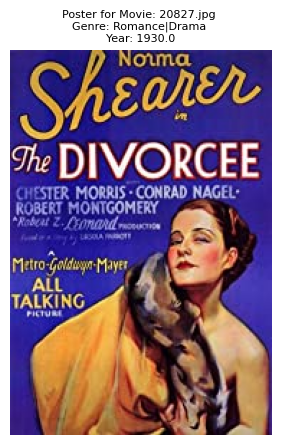

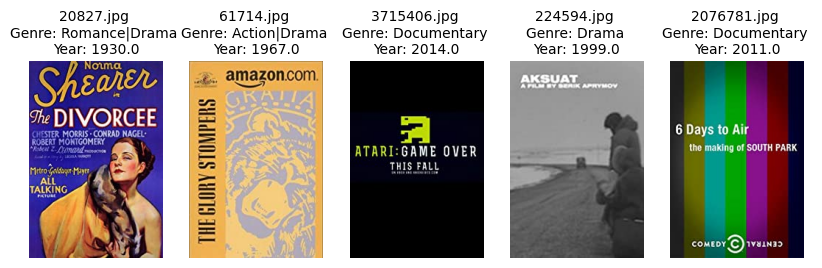

In [15]:

Q_idx = 20827 # YOUR VALUE HERE - DO NOT USE MY VALUE 
k_movie_posters = nearest(images=f"C:/Users/basabdattachaudhury/Downloads/Assignment_2(1) (3)/Assignment_2/DL_Sample/{Q_idx}.jpg", k_neighbors=5, df_movies=df4) 

# Plotting the query image with its genre and year
figure1 = plt.figure(figsize=(5.0, 5.0))
imshow(imread(Q_idx))
plt.title(f"Poster for Movie: {Q_idx}.jpg \nGenre: {df4.loc[df4.index == Q_idx, 'Genre'].item()} \nYear: {df4.loc[df4.index == Q_idx, 'Year'].item()}", fontsize=8)

# Plotting the k nearest neighbor images with their genres and years
figure2 = plt.figure(figsize=(10, 10))
for i, j in enumerate(k_movie_posters):
    img = imread(f"C:/Users/basabdattachaudhury/Downloads/Assignment_2(1) (3)/Assignment_2/DL_Sample/{j}.jpg")
    figure2.add_subplot(1, 5, i+1)    
    imshow(img)
    plt.title(f"{j}.jpg \nGenre: {df4.loc[df4.index == j, 'Genre'].item()} \nYear: {df4.loc[df4.index == j, 'Year'].item()}", fontsize=10)



# COMMENT:
We see some similarity with the posters in the genre but they are not exactly matching. We took 5 neighbours and three of them fall under the Drama category. The ranking might have been better and in the order of the year.  

### Part 4: Year regression

Let's investigate the last question ("similar era") above by running **regression** on the year, ie attempt to predict the year, given the poster. Use a train-test split. Build a suitable Keras neural network model for this, **as a regression head on top of the embedding from Part 1**. Include comments to explain the purpose of each part of the model. It should be possible to make a prediction, given a new poster (not part of the original dataset). Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?

In [16]:


# Get the indices of the rows where the 'Year' column is NaN
nan_year_indices = list(np.where(df4['Year'].isna()))[0].tolist()

# Remove the rows with NaN 'Year' values from the 'years' and 'resized_img_array' arrays
years_n = np.delete(years, nan_year_indices)
new_img_array = np.delete(img_array, nan_year_indices, axis=0)

# Get the unique values of 'new_years' and sort them
new_years_unique = np.unique(years_n)
new_years_unique = sorted(new_years_unique)

# Get the number of unique years as the number of classes
num_classes = len(new_years_unique)


In [17]:
#Splitting the data for training and testing                                                                                 
X_train, X_test, y_train, y_test = train_test_split(new_img_array, years_n, test_size=0.3)

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255   

In [18]:
# Define the input tensor with shape (268, 182, 3)
input_tensor = Input(shape=(268, 182, 3))

# Pass the input tensor to the VGG16 model and get the output
output_vgg16 = model_vgg16(input_tensor)

# Add 3 fully connected layers with tanh activation function
z = layers.Dense(1024, activation='tanh')(output_vgg16)
z = layers.Dense(512, activation='tanh')(z)
z = layers.Dense(256, activation='tanh')(z)

# Add a logistic layer with linear activation function
z = layers.Dense(1)(z)

# Define the new model with input tensor as input and the logistic layer output as output
model_n = Model(inputs=input_tensor, outputs=z)

# Print the model summary
model_n.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 268, 182, 3)]     0         
                                                                 
 model (Functional)          (None, 20480)             14714688  
                                                                 
 dense (Dense)               (None, 1024)              20972544  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 36,343,617
Trainable params: 36,343,617
Non-t

In [19]:
# We will set the hyperparameters
batch_size = 15
epochs = 5

model_n.compile(loss="mean_squared_logarithmic_error", optimizer="RMSprop")
model_n.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
model_n.save("poster_year.saved_model")

Epoch 1/5
52/52 [==============================] - 16s 204ms/step - loss: 19.6828 - val_loss: 16.8949
Epoch 2/5
52/52 [==============================] - 8s 156ms/step - loss: 15.5676 - val_loss: 14.3661
Epoch 3/5
52/52 [==============================] - 8s 156ms/step - loss: 13.4291 - val_loss: 12.5613
Epoch 4/5
52/52 [==============================] - 8s 156ms/step - loss: 11.8524 - val_loss: 11.1873
Epoch 5/5
52/52 [==============================] - 8s 156ms/step - loss: 10.6258 - val_loss: 10.0952
INFO:tensorflow:Assets written to: poster_year.saved_model\assets


In [20]:
score = model_n.evaluate(X_test, y_test, verbose=1)
accur = 100 - score
print("Loss: ", score )
print("Accuracy: ", accur )

12/12 [==============================] - 3s 180ms/step - loss: 10.0857
Loss:  10.085715293884277
Accuracy:  89.91428470611572


### Part 5: Improvements 


Ideas:

* Try a different pretrained model for creating the embedding
* Alternative ways of reducing the pretrained model's output to a flat vector for the embedding
* Gather more data (see the csv file for URLs)
* Add different architectural details to the regression head
* Fine-tuning
* Training an end-to-end convnet of your own design (no pretraining)
* Improve the embedding by training a multi-headed model, eg predicting both genre and year
* Create a good visualisation of the embedding.


In [21]:
#from keras.applications import VGG19

from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19

In [22]:



base_model_vgg19 = VGG19(weights='imagenet', include_top=False) # we will load the pre-trained VGG16 model

input_tensor_vgg19 = Input(shape=(268, 182, 3))

# Passing the input tensor through the VGG16 model to get convolutional output
output_vgg19_convolution = base_model_vgg19(input_tensor_vgg19)

# Adding a flatten layer to the output of VGG16 model
flatten_layer = layers.Flatten(name='flatten')(output_vgg19_convolution)
model_vgg19 = Model(inputs=input_tensor_vgg19, outputs=flatten_layer) # Creating a new model using the VGG16 model input and the flatten layer output


In [23]:
# Define the input tensor with shape (268, 182, 3)
input_tensor = Input(shape=(268, 182, 3))

# Pass the input tensor to the VGG16 model and get the output
output_vgg19 = model_vgg19(input_tensor)

# Add 3 fully connected layers with tanh activation function
z = layers.Dense(1024, activation='tanh')(output_vgg19)
z = layers.Dense(512, activation='tanh')(z)
z = layers.Dense(256, activation='tanh')(z)

# Add a logistic layer with linear activation function
z = layers.Dense(1)(z)

# Define the new model with input tensor as input and the logistic layer output as output
model_n = Model(inputs=input_tensor, outputs=z)

# Print the model summary
model_n.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 268, 182, 3)]     0         
                                                                 
 model_2 (Functional)        (None, 20480)             20024384  
                                                                 
 dense_4 (Dense)             (None, 1024)              20972544  
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 41,653,313
Trainable params: 41,653,313
Non-t

In [24]:
# # We will set new hyperparameters
batch_size = 15
epochs = 15


model_n.compile(loss="mean_squared_logarithmic_error", optimizer="RMSprop")
model_n.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
model_n.save("poster_year.saved_model")

Epoch 1/15
52/52 [==============================] - 11s 186ms/step - loss: 19.9274 - val_loss: 17.3500
Epoch 2/15
52/52 [==============================] - 10s 183ms/step - loss: 15.9493 - val_loss: 14.6813
Epoch 3/15
52/52 [==============================] - 10s 183ms/step - loss: 13.7001 - val_loss: 12.7939
Epoch 4/15
52/52 [==============================] - 10s 183ms/step - loss: 12.0578 - val_loss: 11.3683
Epoch 5/15
52/52 [==============================] - 10s 183ms/step - loss: 10.7887 - val_loss: 10.2413
Epoch 6/15
52/52 [==============================] - 10s 184ms/step - loss: 9.7692 - val_loss: 9.3212
Epoch 7/15
52/52 [==============================] - 10s 184ms/step - loss: 8.9268 - val_loss: 8.5514
Epoch 8/15
52/52 [==============================] - 10s 184ms/step - loss: 8.2153 - val_loss: 7.8952
Epoch 9/15
52/52 [==============================] - 10s 184ms/step - loss: 7.6043 - val_loss: 7.3273
Epoch 10/15
52/52 [==============================] - 10s 184ms/step - loss: 7.072

In [25]:
#Improved model
score = model_n.evaluate(X_test, y_test, verbose=1)
accur = 100 - score
print("Loss: ", score )
print("Accuracy: ", accur )

12/12 [==============================] - 2s 128ms/step - loss: 5.0239
Loss:  5.023895263671875
Accuracy:  94.97610473632812


I have fine tuned the parameters a bit and used a different pretrained model. The performance improved as the accuracy increased from 89.91% to 94.98%.

# REFERENCES

1. Recommending Similar Images using Image Embedding : https://www.analyticsvidhya.com/blog/2022/07/recommending-similar-images-using-image-embedding/

2. How to use a pre-trained model (VGG) for image classification ( Dr. Saptarsi Goswami ) : https://towardsdatascience.com/how-to-use-a-pre-trained-model-vgg-for-image-classification-8dd7c4a4a517

3. LECTURE NOTES: Deep Learning by Dr James McDermott